## Offset model results. 

The only difference between this file and /notebooks/bag_rev_forecast.ipynb is that this runs the same model setup on imputed datasets and displays/saves the results. 

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive
from statsforecast.models import AutoARIMA, AutoETS, AutoTheta
from utilsforecast.losses import mae, mape, rmse  

In [23]:
df_long = pd.read_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/data/reindexed.csv")
df_long = df_long[['unique_id', 'ds', 'y']]
df_long['ds'] = pd.to_datetime(df_long['ds'])


df_long.head()

,unique_id,ds,y
0,Alaska,2015-03-31 23:59:59.999999999,23686.0
1,Alaska,2015-06-30 23:59:59.999999999,30215.0
2,Alaska,2015-09-30 23:59:59.999999999,34127.0
3,Alaska,2015-12-31 23:59:59.999999999,24787.0
4,Alaska,2016-03-31 23:59:59.999999999,30484.0


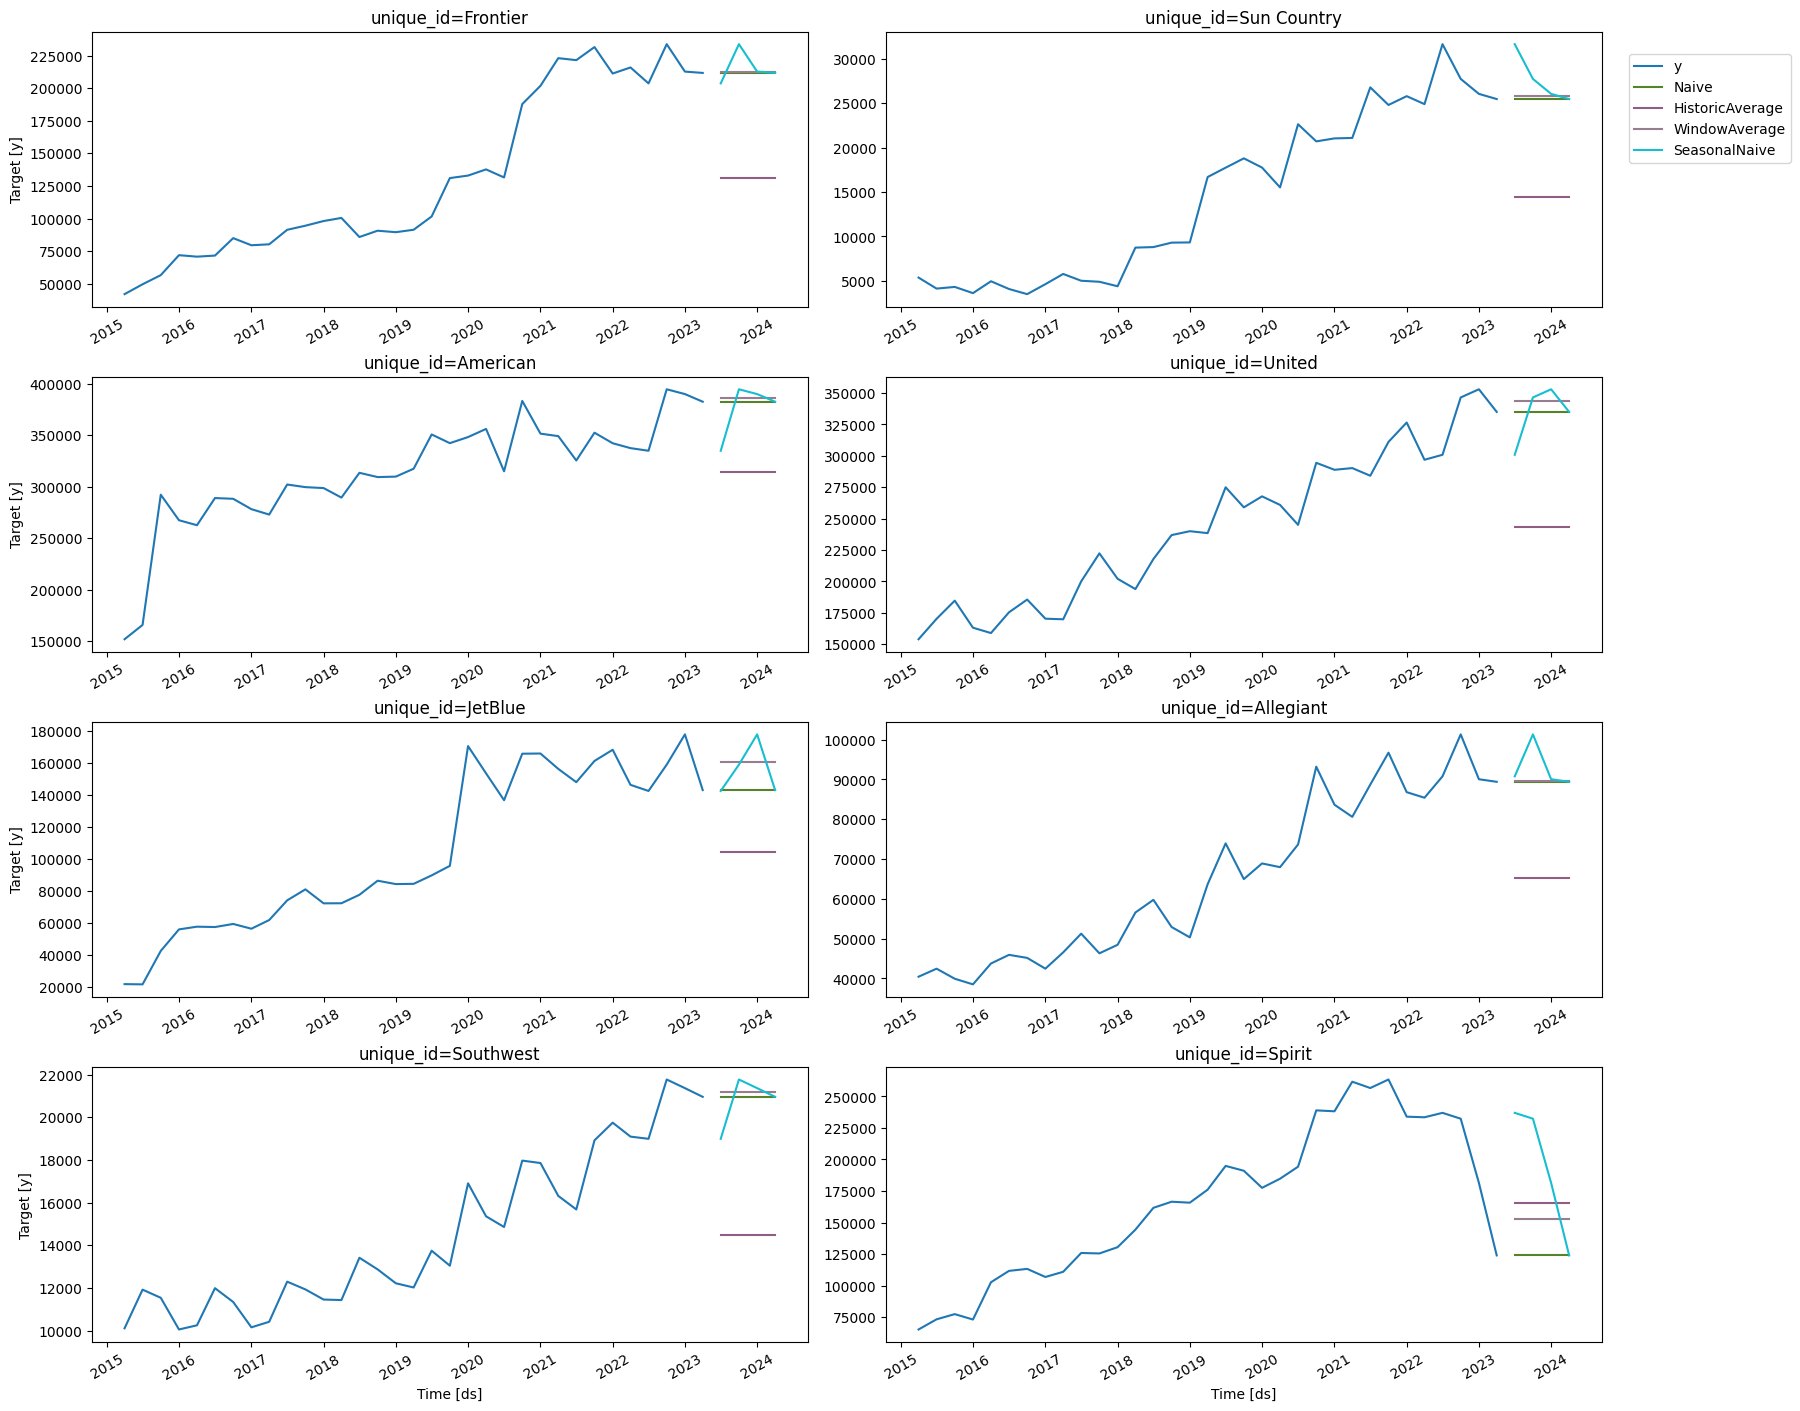

In [24]:
# Baseline models
horizon = 4 # forecasting a year ahead

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=2),
    SeasonalNaive(season_length=4)
]

sf = StatsForecast(models=models, freq='QE')
sf.fit(df=df_long)
preds = sf.predict(h=horizon)
preds.head()
plot_series(df=df_long, forecasts_df=preds)

In [25]:
# Evaluation of Baseline Models

test = df_long.groupby('unique_id').tail(horizon)
train = df_long.drop(test.index).reset_index(drop=True)

In [26]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test, preds, 'left', ['unique_id', 'ds'])

In [27]:
evaluation = evaluate( df=eval_df, metrics=[mae, mape, rmse] )
evaluation

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,Alaska,mae,17402.250000,41313.577586,13205.250000,12066.000000
1,Allegiant,mae,7479.500000,31526.775862,6779.000000,3477.000000
2,American,mae,39311.250000,69899.112069,38124.250000,36102.000000
3,Delta,mae,22376.250000,33826.629310,19082.250000,18836.500000
4,Frontier,mae,9362.500000,95549.172414,8196.000000,6432.750000
5,Hawaiian,mae,4394.750000,2620.456897,3598.500000,3298.500000
6,JetBlue,mae,12802.000000,58088.362069,12802.000000,5167.000000
7,Southwest,mae,1728.250000,7150.129310,1564.750000,2409.750000
8,Spirit,mae,41569.750000,50701.008621,41689.000000,53228.000000
9,Sun Country,mae,2829.250000,15140.456897,2380.250000,2156.500000


In [28]:
# ARIMA and SARIMA Models

unique_ids = df_long["unique_id"].unique().tolist()
small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]


models = [
    AutoARIMA(season_length=1, max_p=6, max_q=6, max_P=3, max_Q=3, alias="ARIMA"),
    AutoARIMA(season_length=4, max_p=6, max_q=6, max_P=3, max_Q=3, alias="SARIMA"),
    AutoETS(season_length=4, alias="ETS"),
    AutoTheta(season_length=4, alias="Theta"),
]

sf = StatsForecast(models=models, freq='QE')
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(test, arima_preds, 'left', ['ds', 'unique_id'])
arima_eval = evaluate( df=arima_eval_df, metrics=[mae, mape, rmse] )
arima_eval

,unique_id,metric,ARIMA,SARIMA,ETS,Theta
0,Alaska,mae,17402.250000,11088.041299,16872.875503,10558.750000
1,Allegiant,mae,5048.374872,5030.940117,5300.316959,5927.765668
2,American,mae,23665.327649,23665.327649,36541.345381,21239.068942
3,Delta,mae,22376.250000,17760.809845,18049.519926,15720.403505
4,Frontier,mae,18674.875000,18674.875000,19038.175591,18012.072899
5,Hawaiian,mae,2011.024490,2640.688895,2623.586109,2729.810503
6,JetBlue,mae,12802.000000,12802.000000,18606.453242,15803.124576
7,Southwest,mae,1177.257028,1108.918392,796.750000,1264.654047
8,Spirit,mae,54846.410714,54846.410714,83010.196915,54906.943927
9,Sun Country,mae,2712.260612,2370.569371,3425.980442,2902.200713


In [ ]:
# Pickling models for later usage

import pickle

with open("/home/rayan/Southwest_stuff/BaggageRevenueModel/models/saved_models/sf_models.pkl", "wb") as f:
    pickle.dump(sf, f)

# Test load 
with open("/home/rayan/Southwest_stuff/BaggageRevenueModel/models/saved_models/sf_models.pkl", "rb") as f:
    sf_loaded = pickle.load(f)

# Test forecast
preds = sf_loaded.predict(h=horizon)

preds.head()


,unique_id,ds,ARIMA,SARIMA,ETS,Theta
0,Alaska,2022-06-30 23:59:59.999999999,84549.000000,80085.971915,90122.111001,96766.682826
1,Alaska,2022-09-30 23:59:59.999999999,84549.000000,96357.471823,93618.519584,99479.110075
2,Alaska,2022-12-31 23:59:59.999999999,84549.000000,98711.398369,83167.674105,102191.537324
3,Alaska,2023-03-31 23:59:59.999999999,84549.000000,87067.992697,84551.415299,104903.964573
4,Allegiant,2022-06-30 23:59:59.999999999,96102.217442,95133.253234,91671.066546,92234.897716


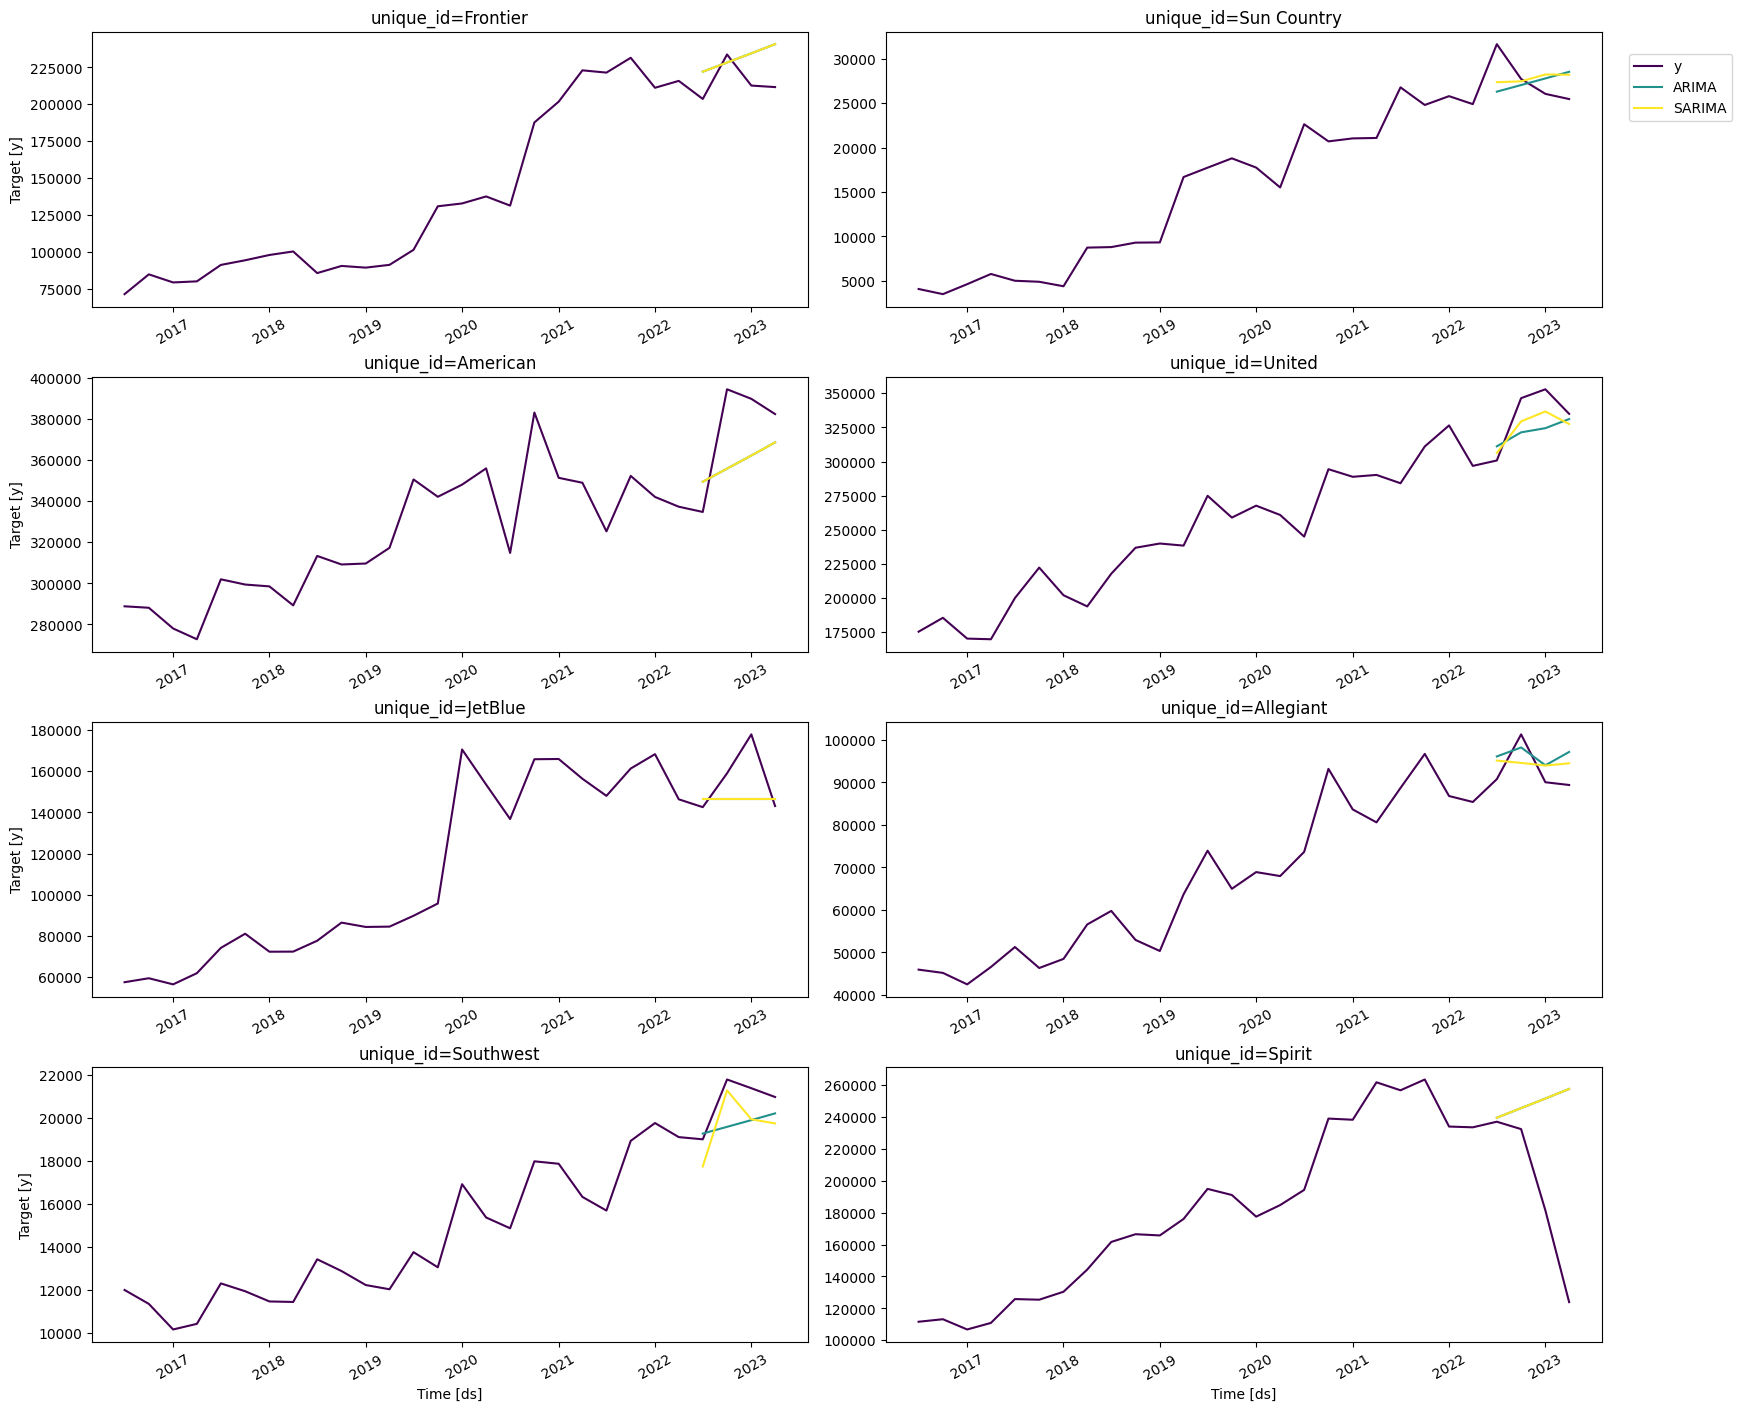

In [8]:
# plotting

ids_to_show = df_long['unique_id'].unique().tolist()
arima_plot = arima_preds[["unique_id","ds","ARIMA","SARIMA"]]

# Make the plot
plot_series(
    df=df_long,                          
    forecasts_df=arima_plot,       
    ids=ids_to_show,          
    max_insample_length=28,    
    palette="viridis"
)

In [9]:
## Cross-Validation
small_df = df_long[df_long["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length=4),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=4, alias="SARIMA")
]

sf = StatsForecast(models=models,  freq="QE")
cv_df = sf.cross_validation(
    h=horizon,
    df=df_long,
    n_windows=4,
    step_size=horizon,
    refit=True
)

cv_df

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,Alaska,2019-06-30 23:59:59.999999999,2019-03-31 23:59:59.999999999,85531.0,77881.0,69691.000000,93526.644430
1,Alaska,2019-09-30 23:59:59.999999999,2019-03-31 23:59:59.999999999,94289.0,83804.0,69691.000000,99449.644430
2,Alaska,2019-12-31 23:59:59.999999999,2019-03-31 23:59:59.999999999,71000.0,69182.0,69691.000000,84827.644430
3,Alaska,2020-03-31 23:59:59.999999999,2019-03-31 23:59:59.999999999,68825.0,69691.0,69691.000000,85336.644430
4,Alaska,2020-06-30 23:59:59.999999999,2020-03-31 23:59:59.999999999,64370.0,85531.0,68825.000000,83366.642487
...,...,...,...,...,...,...,...
171,United,2022-03-31 23:59:59.999999999,2021-03-31 23:59:59.999999999,296843.0,290224.0,308713.365009,308713.365009
172,United,2022-06-30 23:59:59.999999999,2022-03-31 23:59:59.999999999,300800.0,284126.0,311150.104682,306294.996869
173,United,2022-09-30 23:59:59.999999999,2022-03-31 23:59:59.999999999,346431.0,311057.0,321397.721050,329415.063330
174,United,2022-12-31 23:59:59.999999999,2022-03-31 23:59:59.999999999,352933.0,326473.0,324456.067991,336697.378212


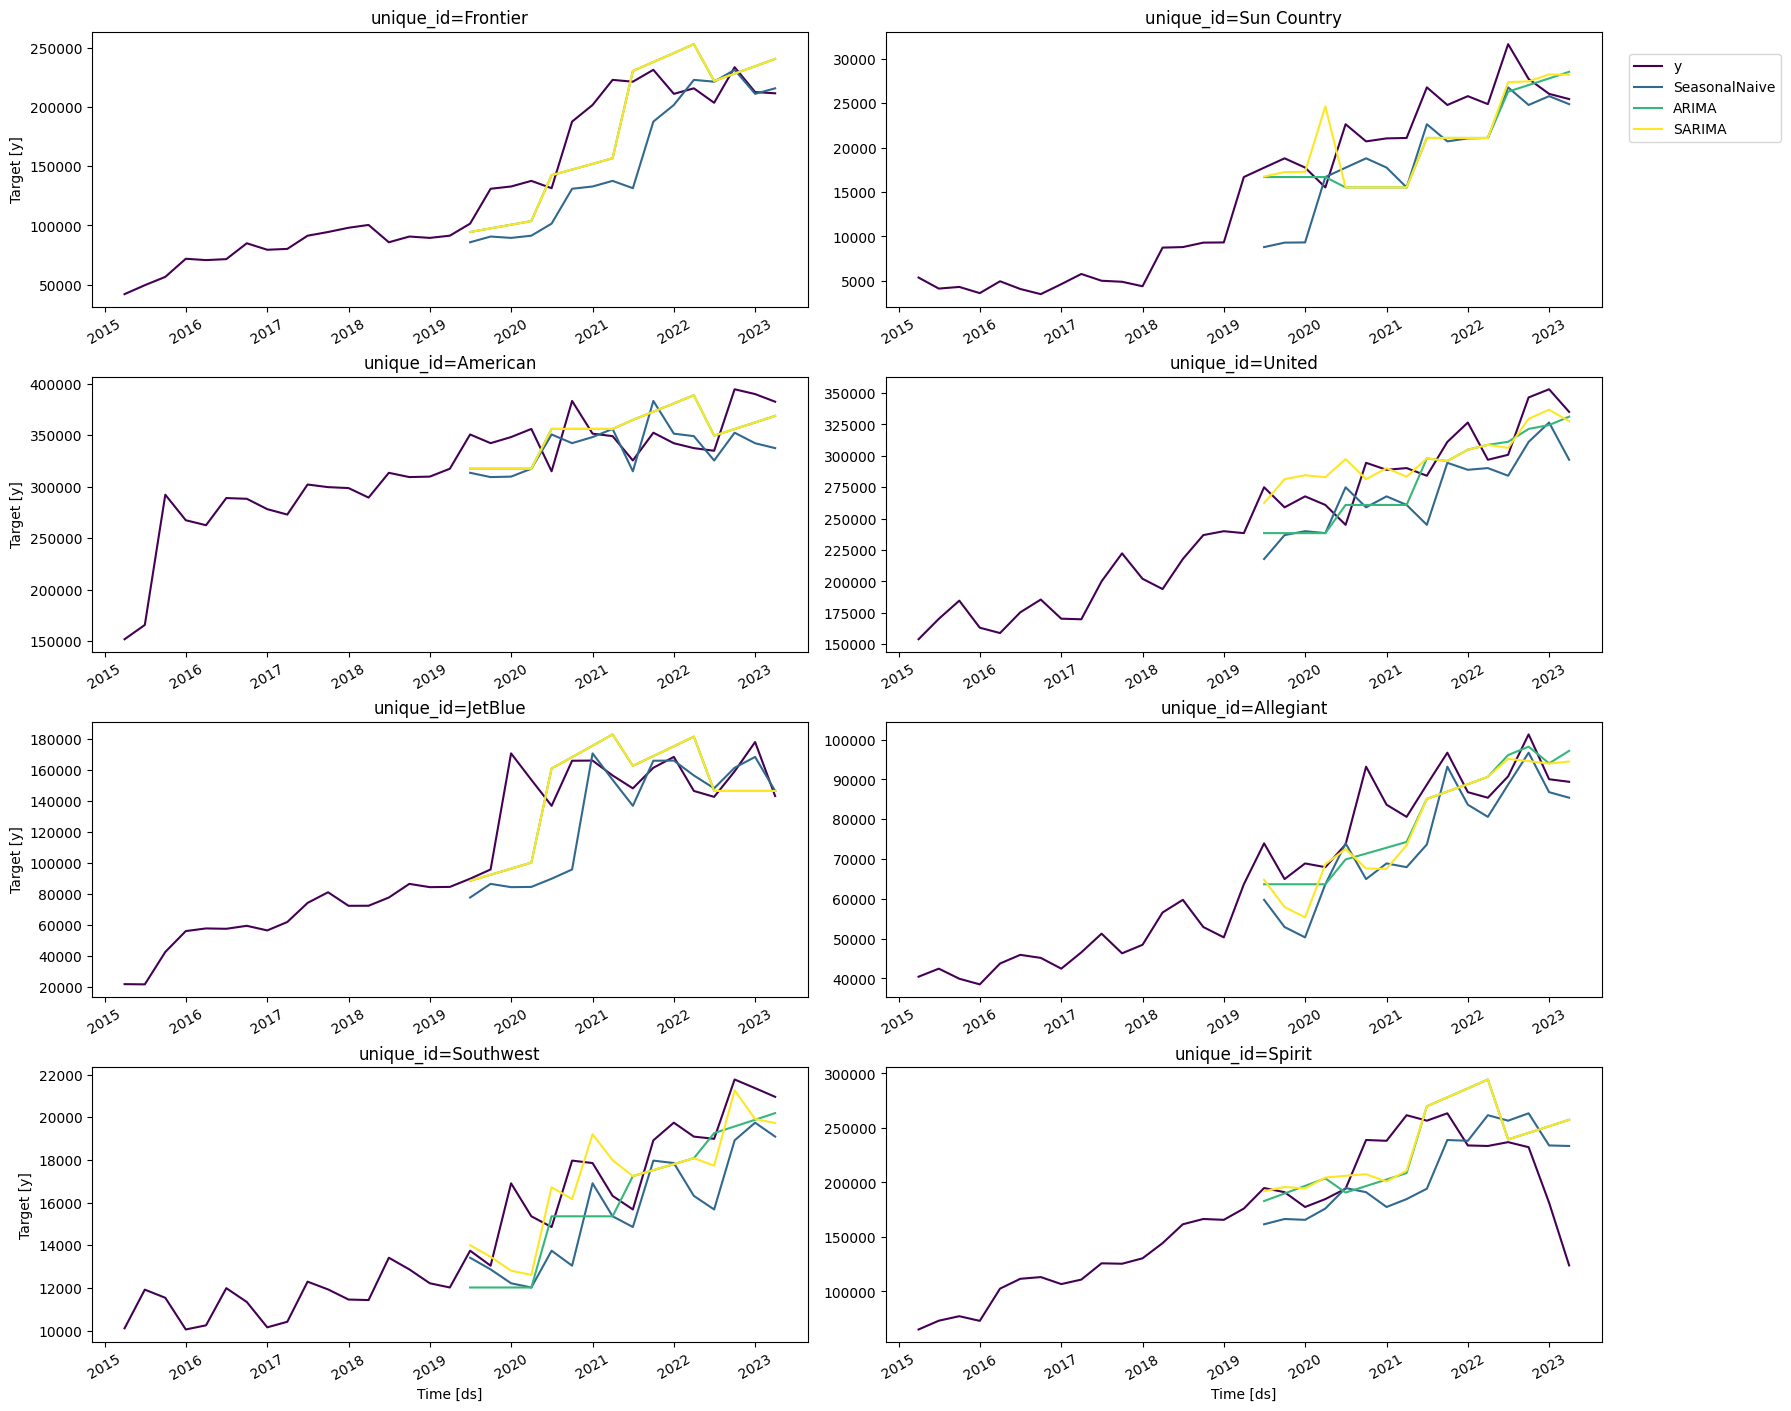

In [10]:
ids_to_show = df_long['unique_id'].unique().tolist()
arima_plot = arima_preds[["unique_id","ds","ARIMA","SARIMA"]]

# Make the plot
plot_series(
    df=small_df,                          
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),      
    ids=ids_to_show,          
    max_insample_length=40,    
    palette="viridis"
)